# Pacotes

In [3]:
# Bibliotecas padrão e manipulação de dados
import os
import pickle
import re
import warnings
from datetime import datetime, date
import numpy as np
import pandas as pd
from pytz import timezone
from unidecode import unidecode

# Configurações e filtros
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno

plt.style.use('ggplot')

# Machine Learning - Modelos e Pré-processamento
import shap
import sklearn
import xgboost as xgb
import lightgbm as lgb
import ppscore as pps
from catboost import Pool
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split, cross_val_score, RepeatedStratifiedKFold, KFold, StratifiedKFold, GridSearchCV
)
from sklearn.metrics import (
    accuracy_score, average_precision_score, classification_report, confusion_matrix, f1_score,
    log_loss, precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve, auc
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import (
    VarianceThreshold, RFE, SelectFromModel, SequentialFeatureSelector, mutual_info_classif, mutual_info_regression
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.inspection import permutation_importance
from sklearn.neighbors import KDTree
from sklearn.tree import DecisionTreeClassifier
from boruta import BorutaPy

# Balanceamento de classes
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.pipeline import make_pipeline

# Estatística e testes de hipótese
from scipy.stats import (
    chi2_contingency, kruskal, ks_2samp, fisher_exact, mannwhitneyu, power_divergence
)
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Modelos avançados e otimização
from hyperopt import fmin, tpe, Trials, hp, STATUS_OK
from hyperopt.pyll import scope
from skopt import forest_minimize

# Avaliação de modelos e explanação
from shap import Explainer

# Salvamento e carregamento de modelos com MLflow
#import mlflow
#from mlflow.models import infer_signature
#import mlflow.lightgbm

import catboost as ctb

# Impressão de versões das bibliotecas utilizadas
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")
print(f"CatBoost version: {ctb.__version__}")
print(f"SHAP version: {shap.__version__}")
print(f"PPScore version: {pps.__version__}")
print(f"missingno version: {msno.__version__}")
#print(f"MLflow version: {mlflow.__version__}")

Pandas version: 2.1.4
NumPy version: 1.26.2
Scikit-learn version: 1.4.2
XGBoost version: 2.0.2
LightGBM version: 4.4.0
CatBoost version: 1.2.2
SHAP version: 0.44.0
PPScore version: 0.0.2
missingno version: 0.5.2


# Carregando Dados

In [4]:
# Carregamento de dados históricos de voos a partir de um arquivo CSV.

# Definindo o caminho do arquivo CSV que contém os dados históricos de voos.
file_path = 'df_voos_completo_2023.csv'

# Lendo o arquivo CSV e carregando os dados em um DataFrame do pandas.
df = pd.read_csv(file_path)

In [5]:
# Mapeamento para dias da semana e meses
mapeamento_dias = {0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira', 3: 'Quinta-feira', 4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'}
mapeamento_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
    7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}

# Aplicando os mapeamentos
df['dia_semana_partida'] = df['dia_semana_partida'].map(mapeamento_dias)
df['dia_semana_chegada'] = df['dia_semana_chegada'].map(mapeamento_dias)
df['mes_partida'] = df['mes_partida'].map(mapeamento_meses)
df['mes_chegada'] = df['mes_chegada'].map(mapeamento_meses)

In [6]:
# Supondo que seu DataFrame seja chamado df
df['altitude_origem'] = df['altitude_origem'].str.replace(',', '.').astype(float)
df['altitude_destino'] = df['altitude_destino'].str.replace(',', '.').astype(float)

In [7]:
# Somente voos realizados
df = df[df['situacao_voo'] == 'REALIZADO']

In [8]:
df = df.drop(columns = ['mes_chegada','dia_semana_chegada','hora_chegada','delta_tempo_partida_int','delta_tempo_partida_delta', 
                        'delta_tempo_chegada_delta','dia_mes_chegada','altitude_origem','altitude_destino',
                        'continente_destino','pais_destino','delta_tempo_chegada_int','dia_semana_chegada',
                        'hora_chegada','data_chegada','data_partida','continente_origem','pais_origem',
                        'situacao_voo','chegada_prevista','chegada_real','partida_real',
                        'partida_prevista','chegada_prevista','chegada_real'])

In [9]:
# Supondo que o seu DataFrame seja df
df['numero_empresa_voo'] = df['nome_empresas'] + "_" + df['numero_voo'].astype(str)

# Dropar a coluna 'numero_voo'
df = df.drop(columns=['numero_voo'])

In [10]:
df = df.dropna()

# PCA redução de dimensionalidade

In [11]:
def aplicar_pca(df, colunas, n_componentes, nome_grupo):
    """
    Aplica PCA em um conjunto de colunas de um DataFrame, adiciona as componentes principais 
    ao DataFrame original e remove as colunas originais.

    Parâmetros:
    -----------
    df : pd.DataFrame
        O DataFrame contendo os dados.
    colunas : list
        Lista de colunas para aplicar o PCA.
    n_componentes : int
        Número de componentes principais a serem mantidos.
    nome_grupo : str
        Nome do grupo para identificação das novas colunas de componentes principais.

    Retorna:
    --------
    pd.DataFrame
        O DataFrame original com as componentes principais adicionadas e colunas originais removidas.
    """
    # Escalar os dados antes de aplicar o PCA
    scaler = StandardScaler()
    dados_escalados = scaler.fit_transform(df[colunas])
    
    # Aplicar o PCA
    pca = PCA(n_components=n_componentes)
    componentes_principais = pca.fit_transform(dados_escalados)
    
    # Adicionar componentes principais ao DataFrame original
    for i in range(n_componentes):
        df[f'{nome_grupo}_pca{i+1}'] = componentes_principais[:, i]
    
    # Remover as colunas originais
    df = df.drop(columns=colunas)
    
    return df

In [12]:
# Aplicação do PCA em cada grupo de colunas
df = aplicar_pca(df, [
    'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__origem', 
    'pressao_atmosferica_max_na_hora_ant_aut_mb__origem', 
    'pressao_atmosferica_min_na_hora_ant_aut_mb__origem'
], n_componentes=1, nome_grupo='pca_pressao_origem')

df = aplicar_pca(df, [
    'umidade_rel_max_na_hora_ant_aut_pcnt__origem', 
    'umidade_rel_min_na_hora_ant_aut_pcnt__origem', 
    'umidade_relativa_do_ar_horaria_pcnt__origem'
], n_componentes=1, nome_grupo='pca_umidade_origem')

df = aplicar_pca(df, [
    'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__destino', 
    'pressao_atmosferica_max_na_hora_ant_aut_mb__destino', 
    'pressao_atmosferica_min_na_hora_ant_aut_mb__destino'
], n_componentes=1, nome_grupo='pca_pressao_destino')

df = aplicar_pca(df, [
    'umidade_rel_max_na_hora_ant_aut_pcnt__destino', 
    'umidade_rel_min_na_hora_ant_aut_pcnt__destino', 
    'umidade_relativa_do_ar_horaria_pcnt__destino'
], n_componentes=1, nome_grupo='pca_umidade_destino')

df = aplicar_pca(df, [
    'temperatura_do_ar_bulbo_seco_horaria_degc__origem', 
    'temperatura_do_ponto_de_orvalho_degc__origem', 
    'temperatura_maxima_na_hora_ant_aut_degc__origem', 
    'temperatura_minima_na_hora_ant_aut_degc__origem', 
    'temperatura_orvalho_max_na_hora_ant_aut_degc__origem', 
    'temperatura_orvalho_min_na_hora_ant_aut_degc__origem'
], n_componentes=1, nome_grupo='pca_temperatura_origem')

df = aplicar_pca(df, [
    'temperatura_do_ar_bulbo_seco_horaria_degc__destino', 
    'temperatura_do_ponto_de_orvalho_degc__destino', 
    'temperatura_maxima_na_hora_ant_aut_degc__destino', 
    'temperatura_minima_na_hora_ant_aut_degc__destino', 
    'temperatura_orvalho_max_na_hora_ant_aut_degc__destino', 
    'temperatura_orvalho_min_na_hora_ant_aut_degc__destino'
], n_componentes=1, nome_grupo='pca_temperatura_destino')


## Testes estatísticos 

### Variance Threshold

In [84]:
from sklearn.feature_selection import VarianceThreshold

In [85]:
def reduzir_cardinalidade(X: pd.DataFrame, threshold: float = 0.05) -> pd.DataFrame:
    """
    Reduz a cardinalidade das variáveis categóricas agrupando categorias menos frequentes em 'Outros'.
    
    Parâmetros:
    -----------
    X : pd.DataFrame
        DataFrame com as variáveis preditoras.
    threshold : float, opcional
        Percentual mínimo de frequência para manter a categoria original. Categorias com frequência abaixo desse valor serão agrupadas.
        O padrão é 0.05 (5%).
    
    Retorna:
    --------
    pd.DataFrame
        DataFrame com a cardinalidade reduzida nas variáveis categóricas.
    """
    X_reduzido = X.copy()
    cols_categoricas = X_reduzido.select_dtypes(include=['object', 'category']).columns
    
    for col in cols_categoricas:
        freq = X_reduzido[col].value_counts(normalize=True)
        categorias_para_manter = freq[freq >= threshold].index
        X_reduzido[col] = X_reduzido[col].apply(lambda x: x if x in categorias_para_manter else 'Outros')
    
    return X_reduzido

In [86]:
def selecao_de_variaveis_variance_threshold(X: pd.DataFrame, threshold: float = 0.0, cardinality_threshold: float = 0.05) -> pd.DataFrame:
    """
    Aplica o método Variance Threshold para selecionar variáveis com base na variância,
    após reduzir a cardinalidade das variáveis categóricas.

    Parâmetros:
    -----------
    X : pd.DataFrame
        O conjunto de dados com as variáveis preditoras.
    threshold : float, opcional
        O limiar de variância. Features com variância abaixo desse valor serão removidas.
        O padrão é 0.0, que remove features com o mesmo valor em todas as amostras.
    cardinality_threshold : float, opcional
        Percentual mínimo de frequência para manter as categorias originais nas variáveis categóricas.
        Categorias com frequência abaixo desse valor serão agrupadas em 'Outros'.
        O padrão é 0.05 (5%).

    Retorna:
    --------
    pd.DataFrame
        DataFrame contendo apenas as variáveis que possuem variância acima do limiar especificado.

    Exceções:
    ---------
    ValueError:
        Se 'X' não for um DataFrame ou se todas as features forem removidas devido ao limiar.

    Exemplo de Uso:
    ---------------
    >>> X_selecionado = selecao_de_variaveis_variance_threshold(X, threshold=0.1, cardinality_threshold=0.05)
    >>> print("Variáveis selecionadas:", X_selecionado.columns.tolist())
    """
    # Verificar se X é um DataFrame
    if not isinstance(X, pd.DataFrame):
        raise ValueError("O parâmetro 'X' deve ser um DataFrame do pandas.")
    
    # Reduzir a cardinalidade das variáveis categóricas
    X_reduzido = reduzir_cardinalidade(X, threshold=cardinality_threshold)
    
    # Identificar colunas não numéricas
    cols_categoricas = X_reduzido.select_dtypes(include=['object', 'category']).columns
    
    # Codificar variáveis categóricas
    if len(cols_categoricas) > 0:
        X_processed = pd.get_dummies(X_reduzido, columns=cols_categoricas, drop_first=False, dummy_na=True)
    else:
        X_processed = X_reduzido.copy()
    
    # Aplicar o Variance Threshold
    selector = VarianceThreshold(threshold=threshold)
    X_selected = selector.fit_transform(X_processed)
    
    # Obter as colunas que foram selecionadas
    features_selecionadas = X_processed.columns[selector.get_support(indices=True)]
    
    # Verificar se alguma feature foi selecionada
    if X_selected.shape[1] == 0:
        raise ValueError("Nenhuma variável foi selecionada. Considere diminuir o valor do 'threshold'.")
    
    # Retornar o DataFrame com as features selecionadas
    X_selecionado = pd.DataFrame(X_selected, columns=features_selecionadas, index=X.index)
    
    return X_selecionado

In [87]:
# Aplicando a função com threshold de variância 0.0 e cardinalidade 0.2 (20%)
X_selecionado = selecao_de_variaveis_variance_threshold(
    X=df,
    threshold=0.0,
    cardinality_threshold=0.2
)

print("\nNúmero de Variáveis Selecionadas:", X_selecionado.shape[1])
print("Variáveis selecionadas:", X_selecionado.columns.tolist())


Número de Variáveis Selecionadas: 36
Variáveis selecionadas: ['codigo_di', 'dia_mes_partida', 'hora_partida', 'latitude_aero_origem', 'longitude_aero_origem', 'latitude_aero_destino', 'longitude_aero_destino', 'precipitacao_total_horario_mm__origem', 'vento_direcao_horaria_gr_deg_gr__origem', 'vento_rajada_maxima_ms__origem', 'vento_velocidade_horaria_ms__origem', 'precipitacao_total_horario_mm__destino', 'vento_direcao_horaria_gr_deg_gr__destino', 'vento_rajada_maxima_ms__destino', 'vento_velocidade_horaria_ms__destino', 'pca_pressao_origem_pca1', 'pca_umidade_origem_pca1', 'pca_pressao_destino_pca1', 'pca_umidade_destino_pca1', 'pca_temperatura_origem_pca1', 'pca_temperatura_destino_pca1', 'nome_empresas_AZUL', 'nome_empresas_GOL', 'nome_empresas_TAM', 'codigo_tipo_linha_N', 'codigo_tipo_linha_Outros', 'status_do_voo_Outros', 'status_do_voo_Pontual', 'uf_origem_Outros', 'uf_origem_SP', 'uf_destino_Outros', 'uf_destino_SP', 'regiao_origem_Outros', 'regiao_origem_SE', 'regiao_destino_

### Chi-quadrado

In [88]:
def variaveis_significativas_chi2(df: pd.DataFrame, y: str, alpha: float = 0.05) -> list:
    """
    Realiza o teste de qui-quadrado para verificar a associação entre variáveis categóricas 
    e a variável dependente. Retorna uma lista de variáveis que são consideradas 
    significativamente associadas à variável dependente com base no valor de p.

    Parâmetros:
    -----------
    df : pd.DataFrame
        O DataFrame que contém os dados.
    y : str
        O nome da variável dependente (target) no DataFrame.
    alpha : float, opcional
        O nível de significância (padrão é 0.05). Variáveis com p-valor menor que alpha serão consideradas significativas.

    Retorna:
    --------
    list
        Uma lista contendo o nome das variáveis preditoras categóricas que têm associação significativa com a variável dependente.
    
    Exceções:
    ---------
    ValueError:
        Levantado se a variável dependente não estiver presente no DataFrame ou se não houver variáveis categóricas.
    """
    
    # Validação de inputs
    if y not in df.columns:
        raise ValueError(f"A variável dependente '{y}' não foi encontrada no DataFrame.")
    
    # Selecionar apenas colunas categóricas para o teste de qui-quadrado, excluindo a variável dependente
    colunas_categ = df.select_dtypes(include=['object']).drop(columns=[y], errors='ignore')
    
    if colunas_categ.empty:
        raise ValueError("Não há variáveis categóricas no DataFrame para realizar o teste de qui-quadrado.")
    
    # Lista de variáveis preditoras
    preditoras = list(colunas_categ)

    # Inicializar lista de colunas significativas
    colunas_significativas = []

    # Loop pelas colunas categóricas e realizar o teste de qui-quadrado
    for coluna in preditoras:
        try:
            tabela_contingencia = pd.crosstab(df[coluna], df[y])
            chi2, p, dof, expected = chi2_contingency(tabela_contingencia)
            if p < alpha:
                colunas_significativas.append(coluna)
        except ValueError as e:
            print(f"Erro ao processar a variável '{coluna}': {e}")
            continue

    return colunas_significativas

In [89]:
# Exemplo de como usar a função
colunas_significativas = variaveis_significativas_chi2(df, 'status_do_voo')
print(colunas_significativas)

['nome_empresas', 'codigo_tipo_linha', 'descricao_origem', 'descricao_destino', 'cidade_origem', 'uf_origem', 'cidade_destino', 'uf_destino', 'mes_partida', 'dia_semana_partida', 'rota', 'regiao_origem', 'regiao_destino', 'numero_empresa_voo']


### Teste G

In [90]:
def variaveis_significativas_teste_g(df: pd.DataFrame, y: str, alpha: float = 0.05) -> list:
    """
    Realiza o Teste G (Log-Likelihood Test) para verificar a associação entre variáveis categóricas 
    e a variável dependente. Retorna uma lista de variáveis que são consideradas 
    significativamente associadas à variável dependente com base no valor de p.
    """
    
    # Validação de inputs
    if y not in df.columns:
        raise ValueError(f"A variável dependente '{y}' não foi encontrada no DataFrame.")
    
    # Selecionar apenas colunas categóricas, excluindo a variável dependente
    colunas_categ = df.select_dtypes(include=['object']).drop(columns=[y], errors='ignore')
    
    if colunas_categ.empty:
        raise ValueError("Não há variáveis categóricas no DataFrame para realizar o Teste G.")

    # Lista de variáveis categóricas
    variaveis_categoricas = list(colunas_categ.columns)

    # Inicializar lista de colunas significativas e dicionário de resultados
    colunas_significativas = []
    resultados_teste_g = {}

    # Loop pelas variáveis categóricas e realizar o Teste G
    for variavel in variaveis_categoricas:
        try:
            tabela_contingencia = pd.crosstab(df[y], df[variavel])
            
            # Realizando o Teste G (Log-Likelihood Test)
            stat, p_valor = power_divergence(tabela_contingencia, lambda_="log-likelihood")
            
            # Garantindo que o p_valor é um float
            if isinstance(p_valor, (list, np.ndarray)):
                p_valor = p_valor[0]
            
            # Verificando se o p-valor é menor que o nível de significância
            if p_valor < alpha:
                colunas_significativas.append(variavel)
            
            # Armazenando os resultados do teste
            resultados_teste_g[variavel] = (stat, p_valor)

        except ValueError as e:
            print(f"Erro ao processar a variável '{variavel}': {e}")
            continue

    return colunas_significativas

In [91]:
# Exemplo de como usar a função
colunas_significativas_g = variaveis_significativas_teste_g(df, 'status_do_voo')
print(colunas_significativas_g)

['nome_empresas', 'codigo_tipo_linha', 'descricao_origem', 'descricao_destino', 'cidade_origem', 'uf_origem', 'cidade_destino', 'uf_destino', 'mes_partida', 'dia_semana_partida', 'regiao_origem', 'regiao_destino', 'numero_empresa_voo']


### Teste exato de fisher

In [92]:
def variaveis_significativas_fisher(df: pd.DataFrame, y: str, alpha: float = 0.05) -> list:
    """
    Realiza o Teste Exato de Fisher para verificar a associação entre variáveis categóricas 
    e a variável dependente. Retorna uma lista de variáveis que são consideradas 
    significativamente associadas à variável dependente com base no valor de p.
    """
    
    # Validação de inputs
    if y not in df.columns:
        raise ValueError(f"A variável dependente '{y}' não foi encontrada no DataFrame.")
    
    # Selecionar apenas colunas categóricas, excluindo a variável dependente
    colunas_categ = df.select_dtypes(include=['object']).drop(columns=[y], errors='ignore')
    
    if colunas_categ.empty:
        raise ValueError("Não há variáveis categóricas no DataFrame para realizar o Teste Exato de Fisher.")
    
    # Lista de variáveis categóricas
    variaveis_categoricas = list(colunas_categ.columns)
    
    # Inicializar lista de colunas significativas e dicionário de resultados
    colunas_significativas_fisher = []
    resultados_fisher = {}

    # Loop pelas variáveis categóricas e realizar o Teste Exato de Fisher
    for variavel in variaveis_categoricas:
        try:
            tabela_contingencia = pd.crosstab(df[y], df[variavel])
            
            # Verificar se a tabela de contingência é 2x2
            if tabela_contingencia.shape == (2, 2):
                # Realizando o Teste Exato de Fisher
                oddsratio, p_valor = fisher_exact(tabela_contingencia)
                
                # Armazenando os resultados
                resultados_fisher[variavel] = (oddsratio, p_valor)
                
                # Verificando se o p-valor é menor que o nível de significância
                if p_valor < alpha:
                    colunas_significativas_fisher.append(variavel)
            else:
                resultados_fisher[variavel] = ('Tabela não é 2x2', 'N/A')

        except ValueError as e:
            print(f"Erro ao processar a variável '{variavel}': {e}")
            continue

    return colunas_significativas_fisher

In [93]:
# Exemplo de como usar a função
colunas_significativas_fisher = variaveis_significativas_fisher(df, 'status_do_voo')
print(colunas_significativas_fisher)

['codigo_tipo_linha']


### kruskal-wallis

In [94]:
def variaveis_significativas_kruskal(df: pd.DataFrame, y: str, grupo1_nome: str, grupo2_nome: str, alpha: float = 0.05) -> list:
    """
    Realiza o teste Kruskal-Wallis para verificar diferenças significativas entre dois grupos 
    de uma variável categórica em relação a variáveis numéricas. 
    Retorna uma lista de variáveis numéricas que têm diferenças significativas com base no valor de p.

    Parâmetros:
    -----------
    df : pd.DataFrame
        O DataFrame que contém os dados.
    y : str
        O nome da variável categórica que contém os grupos (ex.: 'status_do_voo').
    grupo1_nome : str
        O valor da variável categórica que corresponde ao primeiro grupo (ex.: 'Pontual').
    grupo2_nome : str
        O valor da variável categórica que corresponde ao segundo grupo (ex.: 'Atrasado').
    alpha : float, opcional
        O nível de significância (padrão é 0.05). Variáveis com p-valor menor que alpha serão consideradas significativas.

    Retorna:
    --------
    list
        Uma lista contendo o nome das variáveis numéricas que têm diferenças significativas entre os grupos.

    Exceções:
    ---------
    ValueError:
        Levantado se a variável dependente não estiver presente no DataFrame ou se não houver variáveis numéricas.
    """
    
    # Validação de inputs
    if y not in df.columns:
        raise ValueError(f"A variável dependente '{y}' não foi encontrada no DataFrame.")
    
    # Selecionar apenas colunas numéricas
    colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    if not colunas_numericas:
        raise ValueError("Não há colunas numéricas no DataFrame para realizar o teste Kruskal-Wallis.")
    
    # Inicializar lista de colunas significativas e dicionário de resultados
    colunas_significativas_kruskal = []
    resultados_kruskal = {}

    # Loop pelas colunas numéricas e realizar o teste Kruskal-Wallis
    for coluna in colunas_numericas:
        grupo1 = df[df[y] == grupo1_nome][coluna]
        grupo2 = df[df[y] == grupo2_nome][coluna]
        
        # Verificar se os grupos têm valores únicos
        if grupo1.nunique() > 1 and grupo2.nunique() > 1:
            # Realizando o teste Kruskal-Wallis
            k_statistic, p_valor = kruskal(grupo1, grupo2)
            resultados_kruskal[coluna] = (k_statistic, p_valor)
            
            # Verificar se o p-valor é menor que o nível de significância
            if p_valor < alpha:
                colunas_significativas_kruskal.append(coluna)
        else:
            resultados_kruskal[coluna] = ('Valores idênticos', 'N/A')

    return colunas_significativas_kruskal

In [95]:
# Exemplo de como usar a função
colunas_significativas_kruskal = variaveis_significativas_kruskal(df, 'status_do_voo', 'Pontual', 'Atrasado')
print(colunas_significativas_kruskal)

['codigo_di', 'hora_partida', 'latitude_aero_origem', 'longitude_aero_origem', 'latitude_aero_destino', 'longitude_aero_destino', 'precipitacao_total_horario_mm__origem', 'vento_direcao_horaria_gr_deg_gr__origem', 'vento_rajada_maxima_ms__origem', 'vento_velocidade_horaria_ms__origem', 'precipitacao_total_horario_mm__destino', 'vento_direcao_horaria_gr_deg_gr__destino', 'vento_rajada_maxima_ms__destino', 'vento_velocidade_horaria_ms__destino', 'pca_pressao_origem_pca1', 'pca_umidade_origem_pca1', 'pca_pressao_destino_pca1', 'pca_umidade_destino_pca1', 'pca_temperatura_origem_pca1', 'pca_temperatura_destino_pca1']


### V-Crammer

In [96]:
def cramers_v(tabela_contingencia: pd.DataFrame) -> float:
    """
    Calcula o V de Cramer para uma tabela de contingência.
    """
    chi2, _, _, _ = chi2_contingency(tabela_contingencia)
    n = tabela_contingencia.sum().sum()  # Soma total dos valores da tabela
    r, k = tabela_contingencia.shape  # Dimensões da tabela
    return np.sqrt(chi2 / (n * (min(r - 1, k - 1))))

def variaveis_significativas_v_cramer(df: pd.DataFrame, y: str, alpha: float = 0.05) -> list:
    """
    Realiza o teste do V de Cramer para verificar a força da associação entre variáveis categóricas e 
    uma variável dependente categórica. Retorna uma lista de variáveis que são significativamente associadas
    com base no p-valor do teste qui-quadrado.
    """
    
    # Validação de inputs
    if y not in df.columns:
        raise ValueError(f"A variável dependente '{y}' não foi encontrada no DataFrame.")
    
    # Selecionar apenas colunas categóricas, excluindo a variável dependente
    colunas_categ = df.select_dtypes(include=['object']).drop(columns=[y], errors='ignore')
    
    if colunas_categ.empty:
        raise ValueError("Não há variáveis categóricas no DataFrame para realizar o teste do V de Cramer.")

    # Lista de variáveis preditoras
    preditoras = list(colunas_categ)

    # Inicializar lista de colunas significativas e dicionário de resultados
    colunas_significativas = []
    resultados_cramer_v = {}

    # Loop pelas colunas categóricas e realizar o teste do V de Cramer
    for coluna in preditoras:
        tabela_contingencia = pd.crosstab(df[coluna], df[y])
        v_de_cramer = cramers_v(tabela_contingencia)
        
        # Realizar o teste qui-quadrado
        chi2, p, _, _ = chi2_contingency(tabela_contingencia)
        
        # Armazenar os resultados
        resultados_cramer_v[coluna] = {'V de Cramer': v_de_cramer, 'p-valor': p}
        
        # Verificar se o p-valor é menor que o nível de significância
        if p < alpha:
            colunas_significativas.append(coluna)

    return colunas_significativas

In [97]:
# Exemplo de como usar a função
colunas_significativas_v_cramer = variaveis_significativas_v_cramer(df, 'status_do_voo')
print(colunas_significativas_v_cramer)

['nome_empresas', 'codigo_tipo_linha', 'descricao_origem', 'descricao_destino', 'cidade_origem', 'uf_origem', 'cidade_destino', 'uf_destino', 'mes_partida', 'dia_semana_partida', 'rota', 'regiao_origem', 'regiao_destino', 'numero_empresa_voo']


### Mann-Whitney U

In [98]:
def variaveis_significativas_mannwhitney(df: pd.DataFrame, y: str, grupo1_nome: str, grupo2_nome: str, alpha: float = 0.05) -> list:
    """
    Realiza o teste Mann-Whitney U para verificar diferenças significativas entre dois grupos
    de uma variável categórica em relação a variáveis numéricas. Retorna uma lista de variáveis
    numéricas que têm diferenças significativas com base no valor de p.

    Parâmetros:
    -----------
    df : pd.DataFrame
        O DataFrame que contém os dados.
    y : str
        O nome da variável categórica que contém os grupos (ex.: 'status_do_voo').
    grupo1_nome : str
        O valor da variável categórica que corresponde ao primeiro grupo (ex.: 'Pontual').
    grupo2_nome : str
        O valor da variável categórica que corresponde ao segundo grupo (ex.: 'Atrasado').
    alpha : float, opcional
        O nível de significância (padrão é 0.05). Variáveis com p-valor menor que alpha serão consideradas significativas.

    Retorna:
    --------
    list
        Uma lista contendo o nome das variáveis numéricas que têm diferenças significativas entre os grupos.

    Exceções:
    ---------
    ValueError:
        Levantado se a variável dependente não estiver presente no DataFrame ou se não houver variáveis numéricas.
    """
    
    # Validação de inputs
    if y not in df.columns:
        raise ValueError(f"A variável dependente '{y}' não foi encontrada no DataFrame.")
    
    # Selecionar apenas colunas numéricas
    colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    if not colunas_numericas:
        raise ValueError("Não há colunas numéricas no DataFrame para realizar o teste Mann-Whitney U.")
    
    # Tratar valores NaN nas colunas numéricas preenchendo com a mediana
    for coluna in colunas_numericas:
        mediana = df[coluna].median()
        df[coluna] = df[coluna].fillna(mediana)
    
    # Inicializar lista de colunas significativas e dicionário de resultados
    colunas_significativas_mannwhitney = []
    resultados_mannwhitney = {}

    # Loop pelas colunas numéricas e realizar o teste Mann-Whitney U
    for coluna in colunas_numericas:
        grupo1 = df[df[y] == grupo1_nome][coluna]
        grupo2 = df[df[y] == grupo2_nome][coluna]

        # Certificar que há observações suficientes em ambos os grupos
        if len(grupo1) >= 2 and len(grupo2) >= 2:
            # Realizando o teste Mann-Whitney U
            stat, p_valor = mannwhitneyu(grupo1, grupo2)
            resultados_mannwhitney[coluna] = (stat, p_valor)

            # Verificar se o p-valor é menor que o nível de significância
            if p_valor < alpha:
                colunas_significativas_mannwhitney.append(coluna)
    
    return colunas_significativas_mannwhitney

In [99]:
# Exemplo de como usar a função
colunas_significativas_mannwhitney = variaveis_significativas_mannwhitney(df, 'status_do_voo', 'Pontual', 'Atrasado')
print(colunas_significativas_mannwhitney)


['codigo_di', 'hora_partida', 'latitude_aero_origem', 'longitude_aero_origem', 'latitude_aero_destino', 'longitude_aero_destino', 'precipitacao_total_horario_mm__origem', 'vento_direcao_horaria_gr_deg_gr__origem', 'vento_rajada_maxima_ms__origem', 'vento_velocidade_horaria_ms__origem', 'precipitacao_total_horario_mm__destino', 'vento_direcao_horaria_gr_deg_gr__destino', 'vento_rajada_maxima_ms__destino', 'vento_velocidade_horaria_ms__destino', 'pca_pressao_origem_pca1', 'pca_umidade_origem_pca1', 'pca_pressao_destino_pca1', 'pca_umidade_destino_pca1', 'pca_temperatura_origem_pca1', 'pca_temperatura_destino_pca1']


### Teste KS

In [100]:
def variaveis_significativas_ks(df: pd.DataFrame, y: str, grupo1_nome: str, grupo2_nome: str, alpha: float = 0.05) -> list:
    """
    Realiza o teste Kolmogorov-Smirnov (KS) para verificar diferenças significativas na distribuição
    de variáveis numéricas entre dois grupos categóricos. Retorna uma lista de variáveis numéricas que
    têm diferenças significativas com base no valor de p.

    Parâmetros:
    -----------
    df : pd.DataFrame
        O DataFrame que contém os dados.
    y : str
        O nome da variável categórica que contém os grupos (ex.: 'status_do_voo').
    grupo1_nome : str
        O valor da variável categórica que corresponde ao primeiro grupo (ex.: 'Pontual').
    grupo2_nome : str
        O valor da variável categórica que corresponde ao segundo grupo (ex.: 'Atrasado').
    alpha : float, opcional
        O nível de significância (padrão é 0.05). Variáveis com p-valor menor que alpha serão consideradas significativas.

    Retorna:
    --------
    list
        Uma lista contendo o nome das variáveis numéricas que têm diferenças significativas entre os grupos.

    Exceções:
    ---------
    ValueError:
        Levantado se a variável dependente não estiver presente no DataFrame ou se não houver variáveis numéricas.
    """
    
    # Validação de inputs
    if y not in df.columns:
        raise ValueError(f"A variável dependente '{y}' não foi encontrada no DataFrame.")
    
    # Selecionar apenas colunas numéricas
    colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    if not colunas_numericas:
        raise ValueError("Não há colunas numéricas no DataFrame para realizar o teste KS.")
    
    # Tratar valores NaN nas colunas numéricas preenchendo com a mediana
    for coluna in colunas_numericas:
        mediana = df[coluna].median()
        df[coluna] = df[coluna].fillna(mediana)
    
    # Inicializar lista de colunas significativas e dicionário de resultados
    colunas_significativas_ks = []
    resultados_ks = {}

    # Loop pelas colunas numéricas e realizar o teste KS
    for coluna in colunas_numericas:
        grupo1 = df[df[y] == grupo1_nome][coluna]
        grupo2 = df[df[y] == grupo2_nome][coluna]

        # Certificar que há observações suficientes em ambos os grupos
        if len(grupo1) >= 2 and len(grupo2) >= 2:
            # Realizando o teste KS
            stat, p_valor = ks_2samp(grupo1, grupo2)
            resultados_ks[coluna] = (stat, p_valor)

            # Verificar se o p-valor é menor que o nível de significância
            if p_valor < alpha:
                colunas_significativas_ks.append(coluna)
    
    return colunas_significativas_ks

In [101]:
# Exemplo de como usar a função
colunas_significativas_ks = variaveis_significativas_ks(df, 'status_do_voo', 'Pontual', 'Atrasado')
print(colunas_significativas_ks)

['dia_mes_partida', 'hora_partida', 'latitude_aero_origem', 'longitude_aero_origem', 'latitude_aero_destino', 'longitude_aero_destino', 'precipitacao_total_horario_mm__origem', 'vento_direcao_horaria_gr_deg_gr__origem', 'vento_rajada_maxima_ms__origem', 'vento_velocidade_horaria_ms__origem', 'precipitacao_total_horario_mm__destino', 'vento_direcao_horaria_gr_deg_gr__destino', 'vento_rajada_maxima_ms__destino', 'vento_velocidade_horaria_ms__destino', 'pca_pressao_origem_pca1', 'pca_umidade_origem_pca1', 'pca_pressao_destino_pca1', 'pca_umidade_destino_pca1', 'pca_temperatura_origem_pca1', 'pca_temperatura_destino_pca1']


### VIF

In [102]:
def calculate_vif(X):
    # Verifica se há valores NaN e os remove ou imputa
    if X.isnull().values.any():
        X = X.fillna(0)  # ou use uma outra estratégia de imputação

    # Converte todas as colunas para numéricas, se possível
    X = X.apply(pd.to_numeric, errors='coerce')
    
    # Remove qualquer coluna que ainda contenha NaN após a conversão
    X = X.dropna(axis=1)
    
    # Escalar as variáveis pode ajudar na estabilidade do cálculo do VIF
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
    return vif_data

In [103]:
calculate_vif(df)

,feature,VIF
0,codigo_di,1.001324
1,dia_mes_partida,1.000708
2,hora_partida,1.673872
3,latitude_aero_origem,1.772320
4,longitude_aero_origem,1.144670
5,latitude_aero_destino,1.643945
6,longitude_aero_destino,1.139864
7,precipitacao_total_horario_mm__origem,1.086901
8,vento_direcao_horaria_gr_deg_gr__origem,1.014686
9,vento_rajada_maxima_ms__origem,3.487127


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 395046 entries, 0 to 607111
Data columns (total 36 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   nome_empresas                             395046 non-null  object 
 1   codigo_di                                 395046 non-null  int64  
 2   codigo_tipo_linha                         395046 non-null  object 
 3   descricao_origem                          395046 non-null  object 
 4   descricao_destino                         395046 non-null  object 
 5   status_do_voo                             395046 non-null  object 
 6   cidade_origem                             395046 non-null  object 
 7   uf_origem                                 395046 non-null  object 
 8   cidade_destino                            395046 non-null  object 
 9   uf_destino                                395046 non-null  object 
 10  mes_partida              

### Correlaçao

#### Spearman 

In [105]:
def heatmap_correlacao_spearman(df: pd.DataFrame, annot: bool = True, figsize: tuple = (25, 25)):
    """
    Calcula a matriz de correlação de Spearman entre as variáveis numéricas de um DataFrame e
    gera um heatmap para visualização.

    Parâmetros:
    -----------
    df : pd.DataFrame
        O DataFrame que contém os dados.
    annot : bool, opcional
        Se True, exibe os valores das correlações no heatmap. O padrão é True.
    figsize : tuple, opcional
        Tamanho da figura do heatmap. O padrão é (10, 8).

    Retorna:
    --------
    None
        Exibe o heatmap da correlação de Spearman.
    """
    
    # Selecionar apenas colunas numéricas
    df_numerico = df.select_dtypes(include=['float64', 'int64'])
    
    if df_numerico.empty:
        raise ValueError("Não há colunas numéricas no DataFrame para calcular a correlação.")
    
    # Calcular a matriz de correlação de Spearman
    matriz_correlacao = df_numerico.corr(method='spearman')
    
    # Gerar o heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(matriz_correlacao, annot=annot, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
    plt.title('Heatmap de Correlação de Spearman')
    plt.show()

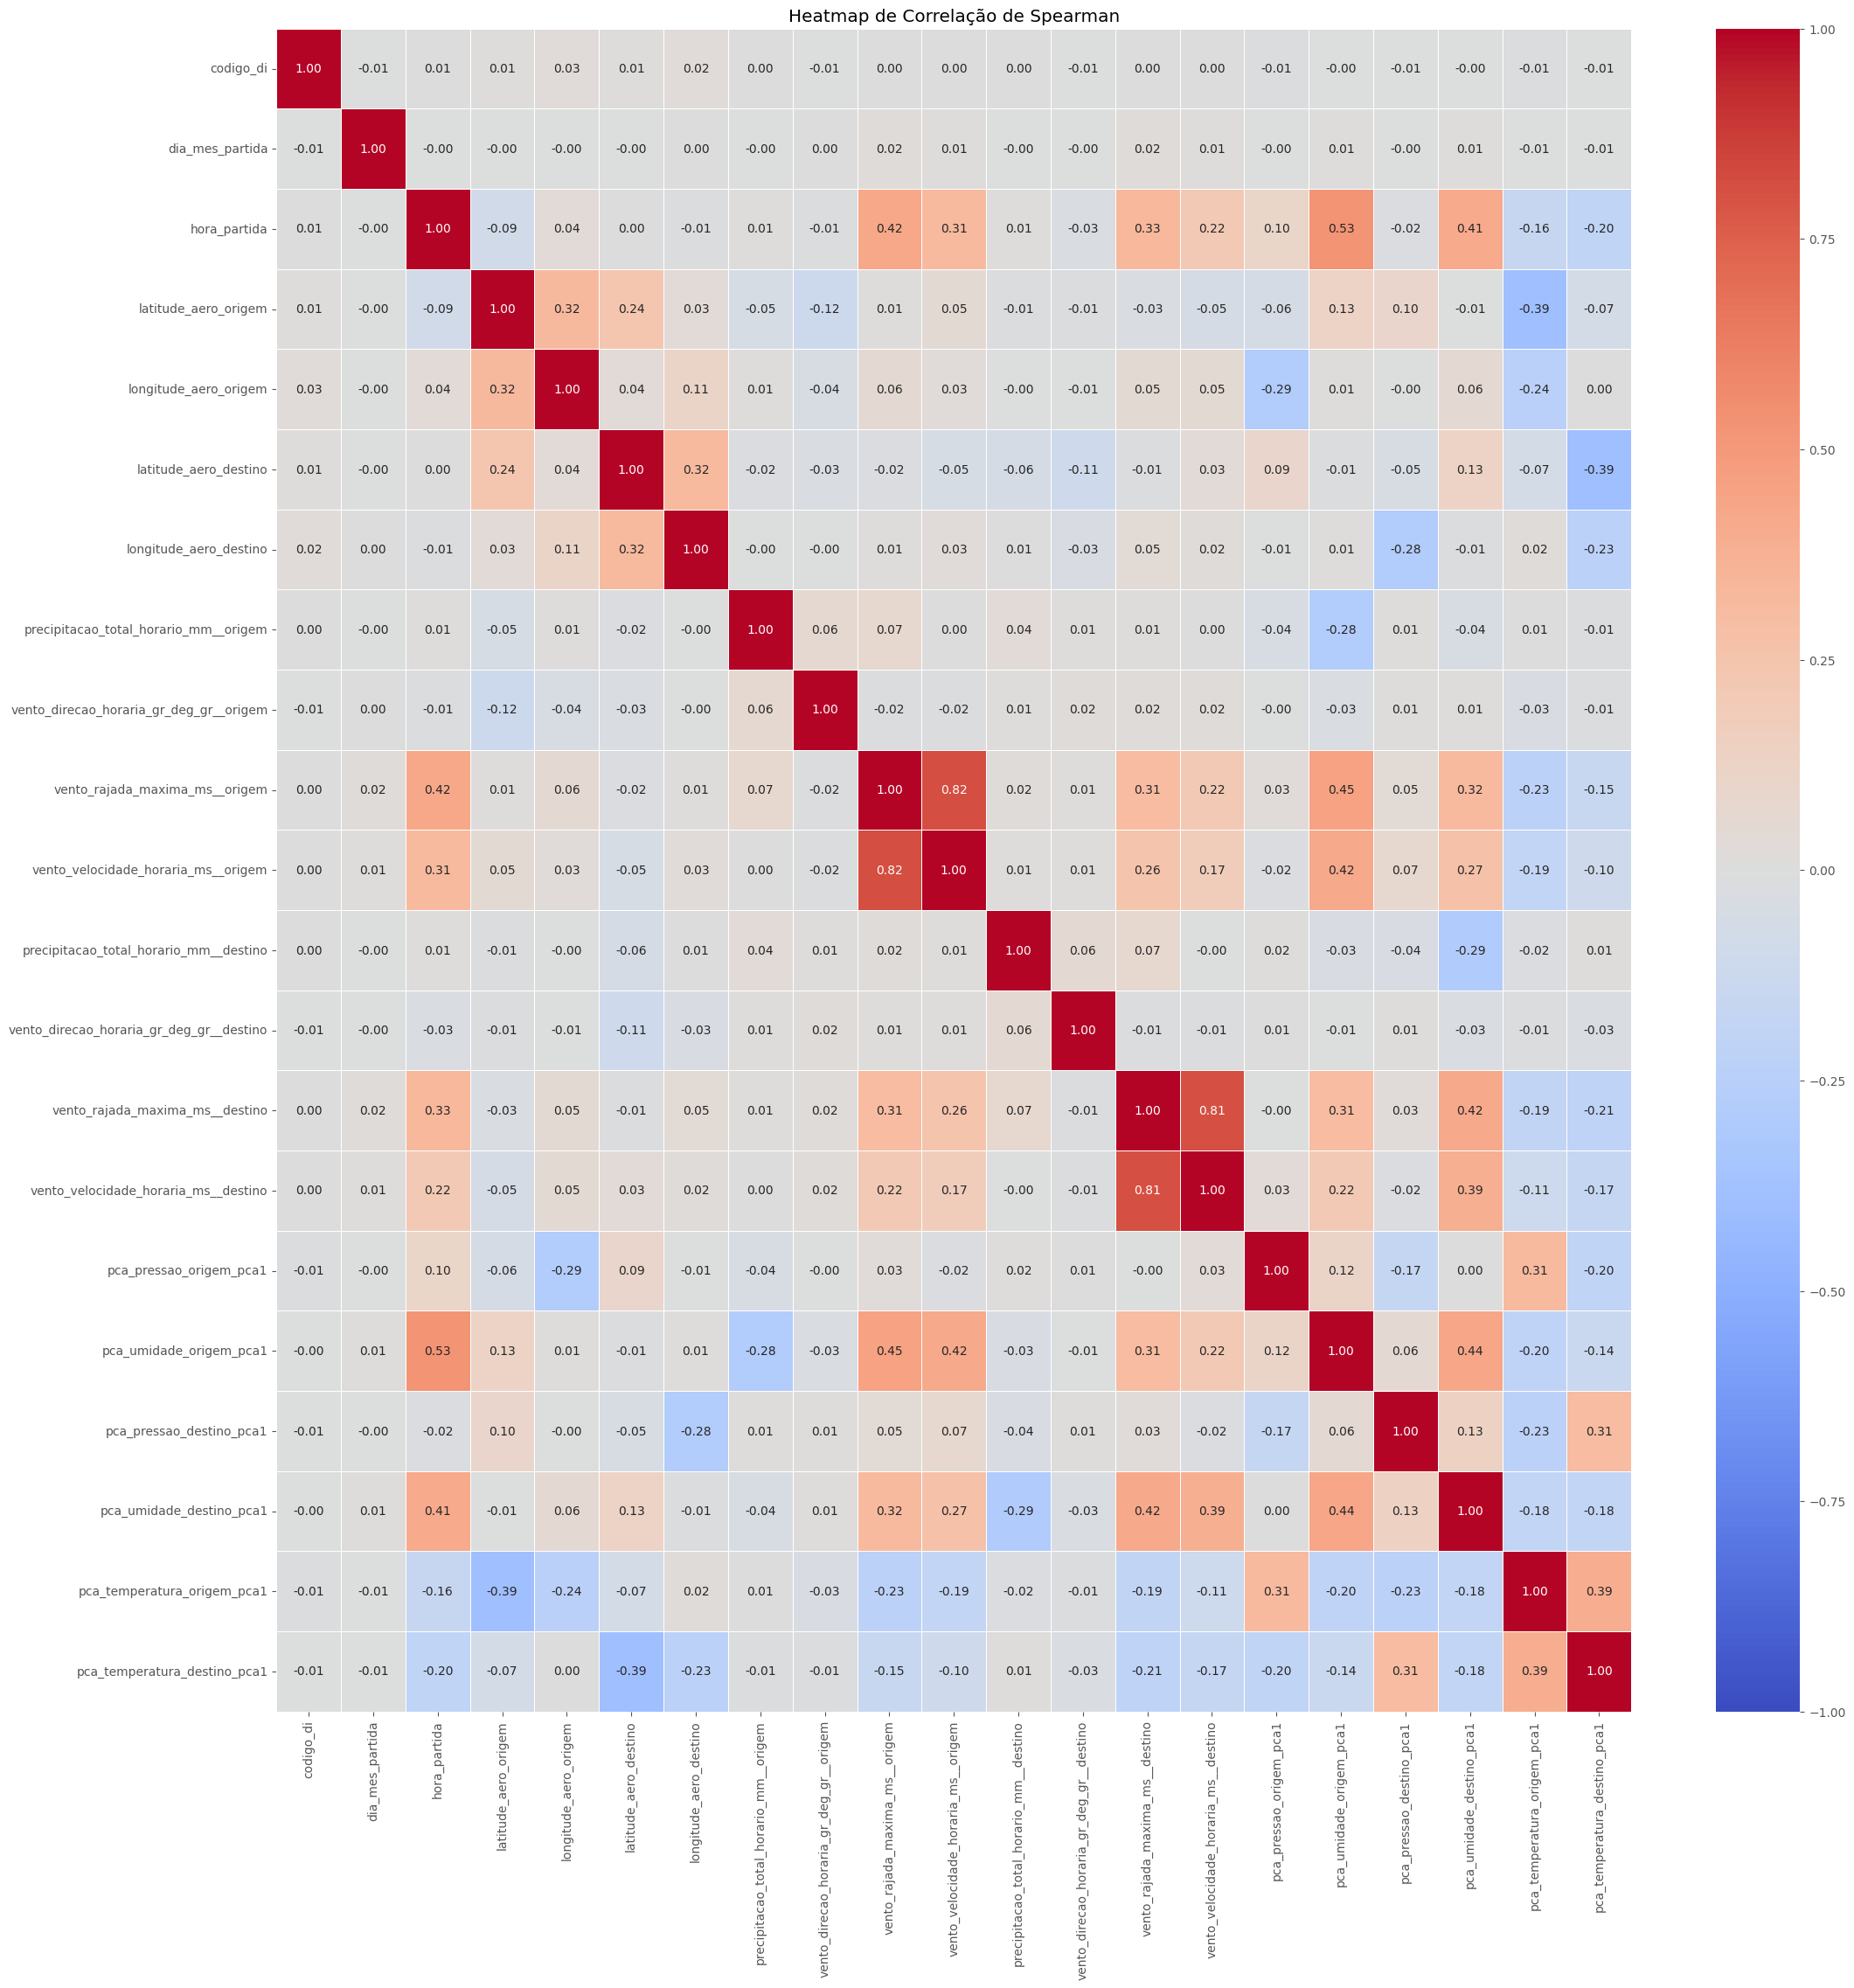

In [106]:
# Exemplo de como usar a função
heatmap_correlacao_spearman(df)

## Algoritmos

### Mutual Information (MI)

In [107]:
def variaveis_significativas_mi(df: pd.DataFrame, y: str, problem_type: str = 'classification', n_features: int = None) -> pd.DataFrame:
    """
    Calcula a Informação Mútua (Mutual Information) entre as variáveis preditoras e a variável alvo.
    Retorna um DataFrame ordenado com as variáveis e seus respectivos scores de MI.

    Parâmetros:
    -----------
    df : pd.DataFrame
        O DataFrame que contém os dados.
    y : str
        O nome da variável dependente (alvo) no DataFrame.
    problem_type : str, opcional
        O tipo de problema: 'classification' para classificação ou 'regression' para regressão. Padrão é 'classification'.
    n_features : int, opcional
        O número de features a serem selecionadas. Se None, retorna todas as features com seus scores.

    Retorna:
    --------
    pd.DataFrame
        DataFrame contendo as variáveis preditoras e seus respectivos scores de Informação Mútua, ordenado do maior para o menor.

    Exceções:
    ---------
    ValueError:
        Levantado se a variável dependente não estiver presente no DataFrame ou se 'problem_type' for inválido.
    """
    # Verificar se a variável alvo está no DataFrame
    if y not in df.columns:
        raise ValueError(f"A variável dependente '{y}' não foi encontrada no DataFrame.")

    # Separar as variáveis preditoras e a variável alvo
    X = df.drop(columns=[y])
    y_data = df[y]

    # Converter variáveis categóricas para numéricas
    X_encoded = X.copy()
    for col in X_encoded.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

    # Converter a variável alvo se for categórica e problema de classificação
    if problem_type == 'classification':
        if y_data.dtype == 'object' or y_data.dtype.name == 'category':
            y_encoded = LabelEncoder().fit_transform(y_data)
        else:
            y_encoded = y_data
        # Calcular a Informação Mútua para classificação
        mi_scores = mutual_info_classif(X_encoded, y_encoded, discrete_features='auto')
    elif problem_type == 'regression':
        y_encoded = y_data
        # Calcular a Informação Mútua para regressão
        mi_scores = mutual_info_regression(X_encoded, y_encoded, discrete_features='auto')
    else:
        raise ValueError("O parâmetro 'problem_type' deve ser 'classification' ou 'regression'.")

    # Criar DataFrame com os resultados
    mi_df = pd.DataFrame({
        'Variável': X.columns,
        'Score_MI': mi_scores
    })

    # Ordenar do maior para o menor score
    mi_df = mi_df.sort_values(by='Score_MI', ascending=False).reset_index(drop=True)

    # Selecionar as top n_features, se especificado
    if n_features is not None:
        mi_df = mi_df.head(n_features)

    return mi_df


In [108]:
# Para um problema de classificação
mi_resultado = variaveis_significativas_mi(df, 'status_do_voo', problem_type='classification')

# Exibindo as variáveis mais significativas
print(mi_resultado)

# Se quiser selecionar apenas as top 10 variáveis
mi_top10 = variaveis_significativas_mi(df, 'status_do_voo', problem_type='classification', n_features=10)
print(mi_top10)

                                    Variável  Score_MI
0                          codigo_tipo_linha  0.063565
1                pca_temperatura_origem_pca1  0.052238
2                    pca_pressao_origem_pca1  0.042205
3               pca_temperatura_destino_pca1  0.034995
4                             regiao_destino  0.033089
5                              regiao_origem  0.032180
6                    pca_umidade_origem_pca1  0.031378
7                              nome_empresas  0.030807
8                         numero_empresa_voo  0.028712
9                   pca_pressao_destino_pca1  0.026373
10                  pca_umidade_destino_pca1  0.019674
11                              hora_partida  0.017733
12                                 uf_origem  0.015858
13                                uf_destino  0.013518
14                        dia_semana_partida  0.013177
15                               mes_partida  0.010391
16                             cidade_origem  0.009776
17        

### ReliefF

In [109]:
def selecao_de_variaveis_relieff(X: pd.DataFrame, y, n_neighbors: int = 10) -> pd.DataFrame:
    """
    Implementa o algoritmo ReliefF para a seleção de variáveis.

    Parâmetros:
    -----------
    X : pd.DataFrame
        O conjunto de dados com as variáveis preditoras.
    y : pd.Series ou np.array
        A variável alvo.
    n_neighbors : int, opcional
        Número de vizinhos a serem considerados pelo algoritmo (padrão é 10).

    Retorna:
    --------
    pd.DataFrame
        DataFrame contendo as variáveis preditoras e seus respectivos scores de relevância, ordenado do maior para o menor.

    Exceções:
    ---------
    ValueError:
        Se 'X' não for um DataFrame ou se 'y' não for uma Série ou array do NumPy.
    """
    # Verificar se X é um DataFrame
    if not isinstance(X, pd.DataFrame):
        raise ValueError("O parâmetro 'X' deve ser um DataFrame do pandas.")

    # Verificar se y é uma Série ou array
    if not isinstance(y, (pd.Series, np.ndarray)):
        raise ValueError("O parâmetro 'y' deve ser uma Série do pandas ou um array do NumPy.")

    # Copiar X para evitar alterações no original
    X_copy = X.copy()

    # Codificar variáveis categóricas em X
    for col in X_copy.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        X_copy[col] = le.fit_transform(X_copy[col].astype(str))

    # Converter X para array NumPy
    X_array = X_copy.values

    # Codificar a variável alvo se for categórica
    if y.dtype.kind in {'O', 'b', 'c', 'S', 'U'} or isinstance(y[0], str):
        y_encoded = LabelEncoder().fit_transform(y)
    else:
        y_encoded = y

    # Obter classes únicas e número de classes
    classes = np.unique(y_encoded)
    n_classes = len(classes)

    # Inicializar o vetor de pesos das features
    n_features = X_array.shape[1]
    weights = np.zeros(n_features)

    # Construir a árvore KD para encontrar vizinhos próximos
    tree = KDTree(X_array)

    # Iterar sobre cada instância
    for idx, (instance, label) in enumerate(zip(X_array, y_encoded)):
        # Encontrar os n_neighbors mais próximos
        distances, indices = tree.query([instance], k=n_neighbors + 1)
        neighbor_indices = indices[0][1:]  # Exclui a própria instância

        # Inicializar contadores
        hit_counts = np.zeros(n_classes)
        miss_counts = np.zeros(n_classes)

        # Calcular as contribuições de hits e misses
        for neighbor_idx in neighbor_indices:
            neighbor_label = y_encoded[neighbor_idx]
            if neighbor_label == label:
                hit_counts[label] += 1
            else:
                miss_counts[neighbor_label] += 1

        # Atualizar pesos das features
        for neighbor_idx in neighbor_indices:
            neighbor_label = y_encoded[neighbor_idx]
            diff = np.abs(instance - X_array[neighbor_idx])

            if neighbor_label == label:
                weights -= diff / (n_neighbors)
            else:
                weights += diff / (n_neighbors * (n_classes - 1))

    # Normalizar pesos para o intervalo [0, 1]
    min_weight = np.min(weights)
    max_weight = np.max(weights)
    if max_weight - min_weight != 0:
        weights = (weights - min_weight) / (max_weight - min_weight)
    else:
        weights = np.zeros_like(weights)

    # Criar DataFrame com os resultados
    relieff_scores = pd.DataFrame({
        'Variável': X_copy.columns,
        'Score_ReliefF': weights
    })

    # Ordenar do maior para o menor score
    relieff_scores = relieff_scores.sort_values(by='Score_ReliefF', ascending=False).reset_index(drop=True)

    return relieff_scores

In [110]:
# Separando as variáveis preditoras e a variável alvo
X = df.drop(columns=['status_do_voo'])
y = df['status_do_voo']

# Aplicando a função de seleção de variáveis com ReliefF
relieff_resultado = selecao_de_variaveis_relieff(X, y, n_neighbors=10)

# Exibindo as variáveis mais significativas
print(relieff_resultado)

                                    Variável  Score_ReliefF
0                              nome_empresas       1.000000
1                          codigo_tipo_linha       0.999954
2                                  codigo_di       0.999336
3                              regiao_origem       0.994813
4                           descricao_origem       0.990095
5                             regiao_destino       0.989107
6                    pca_pressao_origem_pca1       0.982717
7      precipitacao_total_horario_mm__origem       0.981979
8                      longitude_aero_origem       0.980891
9     precipitacao_total_horario_mm__destino       0.980490
10                  pca_pressao_destino_pca1       0.975840
11                                 uf_origem       0.975358
12                      latitude_aero_origem       0.969314
13                    longitude_aero_destino       0.961192
14                             cidade_origem       0.947742
15                     latitude_aero_des

### Information Gain

In [111]:
def variaveis_significativas_information_gain(df: pd.DataFrame, y: str) -> pd.DataFrame:
    """
    Calcula o Ganho de Informação (Information Gain) entre as variáveis preditoras e a variável alvo.
    Retorna um DataFrame ordenado com as variáveis e seus respectivos scores de Information Gain.

    Parâmetros:
    -----------
    df : pd.DataFrame
        O DataFrame que contém os dados.
    y : str
        O nome da variável dependente (alvo) no DataFrame.

    Retorna:
    --------
    pd.DataFrame
        DataFrame contendo as variáveis preditoras e seus respectivos scores de Information Gain, ordenado do maior para o menor.

    Exceções:
    ---------
    ValueError:
        Levantado se a variável dependente não estiver presente no DataFrame.
    """
    # Verificar se a variável alvo está no DataFrame
    if y not in df.columns:
        raise ValueError(f"A variável dependente '{y}' não foi encontrada no DataFrame.")

    # Separar a variável alvo e as preditoras
    X = df.drop(columns=[y])
    y_data = df[y]

    # Converter a variável alvo para numérica se for categórica
    if y_data.dtype == 'object' or y_data.dtype.name == 'category':
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_data)
    else:
        y_encoded = y_data.values

    # Calcular a entropia da variável alvo
    def calcular_entropia(y):
        _, counts = np.unique(y, return_counts=True)
        probabilidades = counts / len(y)
        entropia = -np.sum(probabilidades * np.log2(probabilidades))
        return entropia

    entropia_y = calcular_entropia(y_encoded)

    # Inicializar lista para armazenar os ganhos de informação
    information_gain_list = []

    # Iterar sobre as colunas preditoras
    for coluna in X.columns:
        x_coluna = X[coluna]

        # Tratar variáveis categóricas
        if x_coluna.dtype == 'object' or x_coluna.dtype.name == 'category':
            x_coluna = x_coluna.astype(str)
        else:
            x_coluna = x_coluna.fillna(x_coluna.median())

        # Codificar a variável preditora se for categórica
        if x_coluna.dtype == 'object':
            x_encoded = LabelEncoder().fit_transform(x_coluna)
        else:
            x_encoded = x_coluna.values

        # Calcular a entropia condicional H(Y|X)
        def calcular_entropia_condicional(x, y):
            valores_x, counts_x = np.unique(x, return_counts=True)
            entropia_condicional = 0
            for valor_x, count_x in zip(valores_x, counts_x):
                y_subset = y[x == valor_x]
                entropia_y_given_x = calcular_entropia(y_subset)
                prob_x = count_x / len(x)
                entropia_condicional += prob_x * entropia_y_given_x
            return entropia_condicional

        entropia_condicional = calcular_entropia_condicional(x_encoded, y_encoded)

        # Calcular o ganho de informação
        information_gain = entropia_y - entropia_condicional

        # Armazenar o resultado
        information_gain_list.append({'Variável': coluna, 'Information_Gain': information_gain})

    # Criar DataFrame com os resultados
    ig_df = pd.DataFrame(information_gain_list)

    # Ordenar do maior para o menor score
    ig_df = ig_df.sort_values(by='Information_Gain', ascending=False).reset_index(drop=True)

    return ig_df

In [112]:
# Calculando o Information Gain para cada variável preditora
ig_resultado = variaveis_significativas_information_gain(df, 'status_do_voo')

# Exibindo as variáveis mais significativas
print(ig_resultado)

                                    Variável  Information_Gain
0                pca_temperatura_origem_pca1          0.284515
1               pca_temperatura_destino_pca1          0.276150
2                    pca_pressao_origem_pca1          0.153405
3                   pca_pressao_destino_pca1          0.138333
4                    pca_umidade_origem_pca1          0.087855
5                   pca_umidade_destino_pca1          0.073766
6                         numero_empresa_voo          0.048962
7                               hora_partida          0.020102
8                                       rota          0.012902
9             vento_rajada_maxima_ms__origem          0.012708
10           vento_rajada_maxima_ms__destino          0.009662
11   vento_direcao_horaria_gr_deg_gr__origem          0.008048
12       vento_velocidade_horaria_ms__origem          0.007144
13                               mes_partida          0.006730
14                     longitude_aero_origem          0

### Information Value IV

In [113]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def calcular_information_value(df: pd.DataFrame, y: str, bins=10, show_woe=False) -> pd.DataFrame:
    """
    Calcula o Information Value (IV) e o Weight of Evidence (WoE) para cada variável preditora em relação à variável alvo binária.
    
    Parâmetros:
    -----------
    df : pd.DataFrame
        O DataFrame que contém os dados.
    y : str
        O nome da variável dependente (alvo binária) no DataFrame.
    bins : int, opcional
        Número de bins para discretização das variáveis numéricas (padrão é 10).
    show_woe : bool, opcional
        Se True, retorna também os valores de WoE para cada bin de cada variável (padrão é False).
    
    Retorna:
    --------
    pd.DataFrame
        DataFrame contendo as variáveis preditoras e seus respectivos Information Values (IV), ordenado do maior para o menor.
        Se show_woe for True, retorna também os valores de WoE para cada variável.
    
    Exceções:
    ---------
    ValueError:
        Levantado se a variável dependente não for binária ou não estiver presente no DataFrame.
    """
    # Verificar se a variável alvo está no DataFrame
    if y not in df.columns:
        raise ValueError(f"A variável dependente '{y}' não foi encontrada no DataFrame.")
    
    # Verificar se a variável alvo é binária
    if df[y].nunique() != 2:
        raise ValueError("A variável dependente deve ser binária.")
    
    # Criar uma cópia do DataFrame para não alterar o original
    df_copy = df.copy()
    
    # Codificar a variável alvo para 0 e 1
    le = LabelEncoder()
    df_copy[y] = le.fit_transform(df_copy[y])
    
    # Inicializar lista para armazenar os resultados
    iv_list = []
    woe_dict = {}
    
    # Calcular o total de eventos e não eventos
    total_eventos = df_copy[y].sum()
    total_nao_eventos = df_copy[y].count() - total_eventos
    
    # Iterar sobre as colunas preditoras
    for coluna in df_copy.drop(columns=[y]).columns:
        # Copiar a coluna para manipulação
        x = df_copy[coluna]
        
        # Tratar variáveis numéricas e categóricas
        if pd.api.types.is_numeric_dtype(x):
            # Discretizar variáveis numéricas
            x_binned, bins_edges = pd.qcut(x, q=bins, duplicates='drop', retbins=True)
        else:
            # Para variáveis categóricas, usar os valores originais
            x_binned = x.astype(str)
        
        # Criar DataFrame com as contagens
        df_agg = pd.DataFrame({
            'Total': x_binned.value_counts().sort_index(),
            'Eventos': df_copy.groupby(x_binned)[y].sum()
        })
        df_agg['Nao_Eventos'] = df_agg['Total'] - df_agg['Eventos']
        
        # Calcular as proporções
        df_agg['Prop_Eventos'] = df_agg['Eventos'] / total_eventos
        df_agg['Prop_Nao_Eventos'] = df_agg['Nao_Eventos'] / total_nao_eventos
        
        # Substituir zeros para evitar divisão por zero
        df_agg['Prop_Eventos'] = df_agg['Prop_Eventos'].replace(0, 0.0001)
        df_agg['Prop_Nao_Eventos'] = df_agg['Prop_Nao_Eventos'].replace(0, 0.0001)
        
        # Calcular o WoE e o IV
        df_agg['WoE'] = np.log(df_agg['Prop_Eventos'] / df_agg['Prop_Nao_Eventos'])
        df_agg['IV'] = (df_agg['Prop_Eventos'] - df_agg['Prop_Nao_Eventos']) * df_agg['WoE']
        iv = df_agg['IV'].sum()
        
        # Armazenar o IV da variável
        iv_list.append({'Variável': coluna, 'Information_Value': iv})
        
        # Armazenar o WoE se solicitado
        if show_woe:
            woe_dict[coluna] = df_agg[['WoE']]
    
    # Criar DataFrame com os resultados
    iv_df = pd.DataFrame(iv_list)
    iv_df = iv_df.sort_values(by='Information_Value', ascending=False).reset_index(drop=True)
    
    # Se show_woe for True, retornar também o dicionário de WoE
    if show_woe:
        return iv_df, woe_dict
    else:
        return iv_df

In [114]:
# Calculando o Information Value para cada variável preditora
iv_resultado = calcular_information_value(df, y='status_do_voo', bins=10, show_woe=False)

# Exibindo as variáveis mais significativas
print(iv_resultado)

                                    Variável  Information_Value
0                         numero_empresa_voo           0.649321
1                               hora_partida           0.190766
2                                       rota           0.145533
3             vento_rajada_maxima_ms__origem           0.068235
4                                mes_partida           0.067201
5                           descricao_origem           0.064684
6                              cidade_origem           0.064302
7                    pca_pressao_origem_pca1           0.062923
8            vento_rajada_maxima_ms__destino           0.060208
9                                  uf_origem           0.054029
10                     longitude_aero_origem           0.041999
11                      latitude_aero_origem           0.039503
12                             nome_empresas           0.038331
13                        dia_semana_partida           0.038094
14              pca_temperatura_destino_

## Uso de modelos

In [15]:
colunas_categ = df.select_dtypes(include=['object']).columns.tolist()
colunas_categ

['nome_empresas',
 'codigo_tipo_linha',
 'descricao_origem',
 'descricao_destino',
 'status_do_voo',
 'cidade_origem',
 'uf_origem',
 'cidade_destino',
 'uf_destino',
 'mes_partida',
 'dia_semana_partida',
 'rota',
 'regiao_origem',
 'regiao_destino',
 'numero_empresa_voo']

In [16]:
# Selecionar apenas colunas numéricas
colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
colunas_numericas

['codigo_di',
 'dia_mes_partida',
 'hora_partida',
 'latitude_aero_origem',
 'longitude_aero_origem',
 'latitude_aero_destino',
 'longitude_aero_destino',
 'precipitacao_total_horario_mm__origem',
 'vento_direcao_horaria_gr_deg_gr__origem',
 'vento_rajada_maxima_ms__origem',
 'vento_velocidade_horaria_ms__origem',
 'precipitacao_total_horario_mm__destino',
 'vento_direcao_horaria_gr_deg_gr__destino',
 'vento_rajada_maxima_ms__destino',
 'vento_velocidade_horaria_ms__destino',
 'pca_pressao_origem_pca1',
 'pca_umidade_origem_pca1',
 'pca_pressao_destino_pca1',
 'pca_umidade_destino_pca1',
 'pca_temperatura_origem_pca1',
 'pca_temperatura_destino_pca1']

###  Pre-treino para feature selection

In [17]:
df_feature = df
# Seleção das features(variaveis) preditoras
dt_ax = df_feature.drop(columns = ['status_do_voo'])

# Seleção da variavel a ser predita a probabilidade
dt_ay = df_feature[['status_do_voo']].copy()

label_encoder = LabelEncoder()
dt_ay = label_encoder.fit_transform(dt_ay)

list_dummies = ['nome_empresas', 'numero_empresa_voo', 'codigo_tipo_linha',
 'descricao_origem', 'descricao_destino', 'cidade_origem',
 'uf_origem', 'cidade_destino', 'uf_destino',
 'mes_partida', 'dia_semana_partida', 'rota',
 'regiao_origem', 'regiao_destino']

dt_ax_dummies = pd.get_dummies(dt_ax, columns=list_dummies, dummy_na=True)

# Segmentação em Treino (75%) e Teste (25%)
X_train_hot, X_test_hot, y_train_hot, y_test_hot = train_test_split(dt_ax_dummies, dt_ay, random_state=42, test_size=0.25)

# Segmentação em Treino (75%) e Teste (25%)
X_train, X_test, y_train, y_test = train_test_split(dt_ax, dt_ay, random_state=42, test_size=0.25)

In [18]:
# XGBoost
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train_hot,y_train_hot)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [19]:
# Catboost
cat_features =  list(dt_ax.select_dtypes(include=['object']))

model_ctb = ctb.CatBoostClassifier( cat_features = cat_features)
model_ctb.fit(dt_ax, dt_ay, cat_features=cat_features, verbose=False)

print('CatBoost model is fitted: ' + str(model_ctb.is_fitted()))

CatBoost model is fitted: True


### Feature Importance

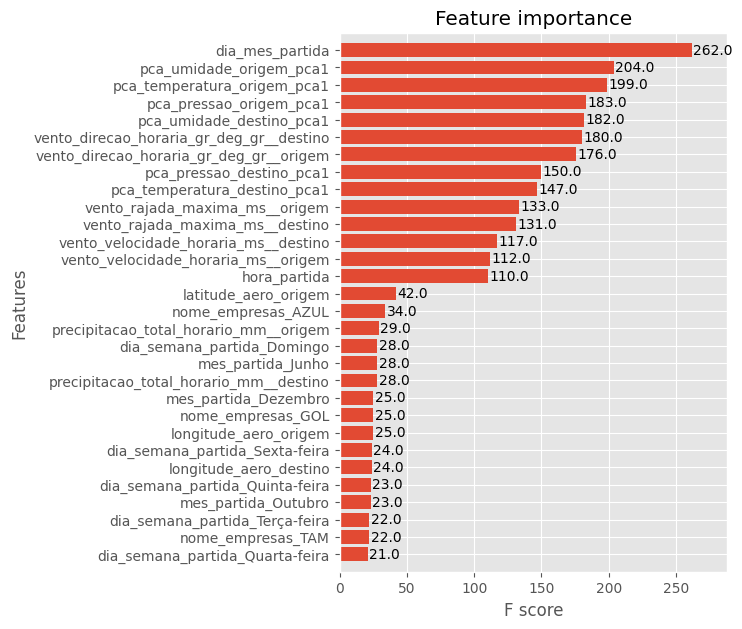

In [121]:
fig, ax = plt.subplots(figsize=(5,7))
xgb.plot_importance(model_xgb, max_num_features=30, height=0.8, ax=ax)
plt.show()

Text(0.5, 1.0, 'Feature Importance CatBoost')

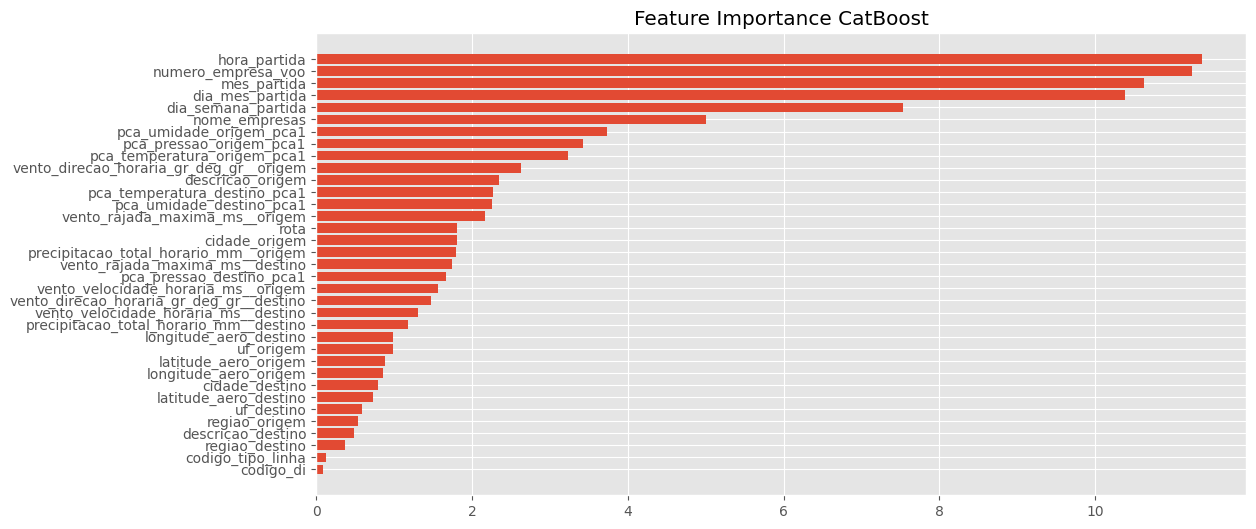

In [122]:
feature_importance = model_ctb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance CatBoost')

### Permutation Importance

In [ ]:
%%time
perm_importance = permutation_importance(model_xgb, X_test_hot, y_test_hot, n_repeats=10, random_state=123)

top_n = 25
# Ordenando as características pela importância e selecionando as top_n
sorted_idx = perm_importance.importances_mean.argsort()[-top_n:]

# Criando o gráfico de barras horizontal
plt.figure(figsize=(10, 8))  # Ajuste o tamanho conforme necessário
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')

# Definindo os y-ticks para serem os nomes das características
plt.yticks(range(len(sorted_idx)), np.array(X_test_hot.columns)[sorted_idx])

# Título do gráfico
plt.title('Top {} Features Permutation Importance'.format(top_n))

# Layout apertado para arranjo visual limpo
plt.tight_layout()

# Mostrar o gráfico
plt.show()

CPU times: total: 22min 34s
Wall time: 6min 28s


Text(0.5, 1.0, 'Permutation Importance')

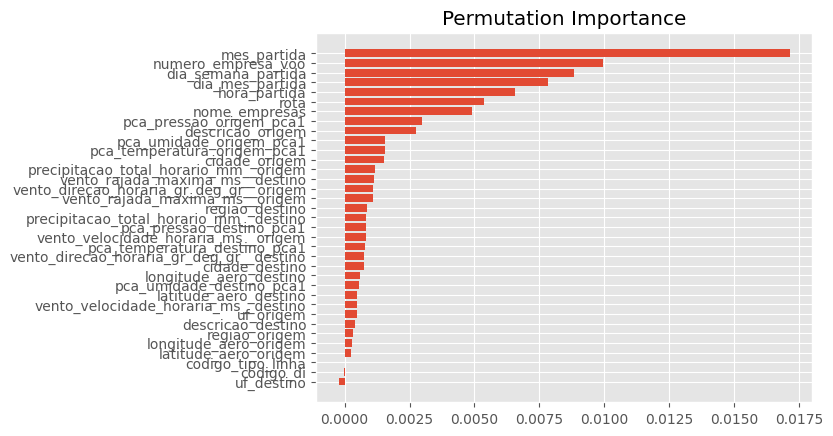

In [22]:
%%time
perm_importance = permutation_importance(model_ctb, X_test, y_test, n_repeats=25, random_state=123)
sorted_idx = perm_importance.importances_mean.argsort()
#fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')

### Shap

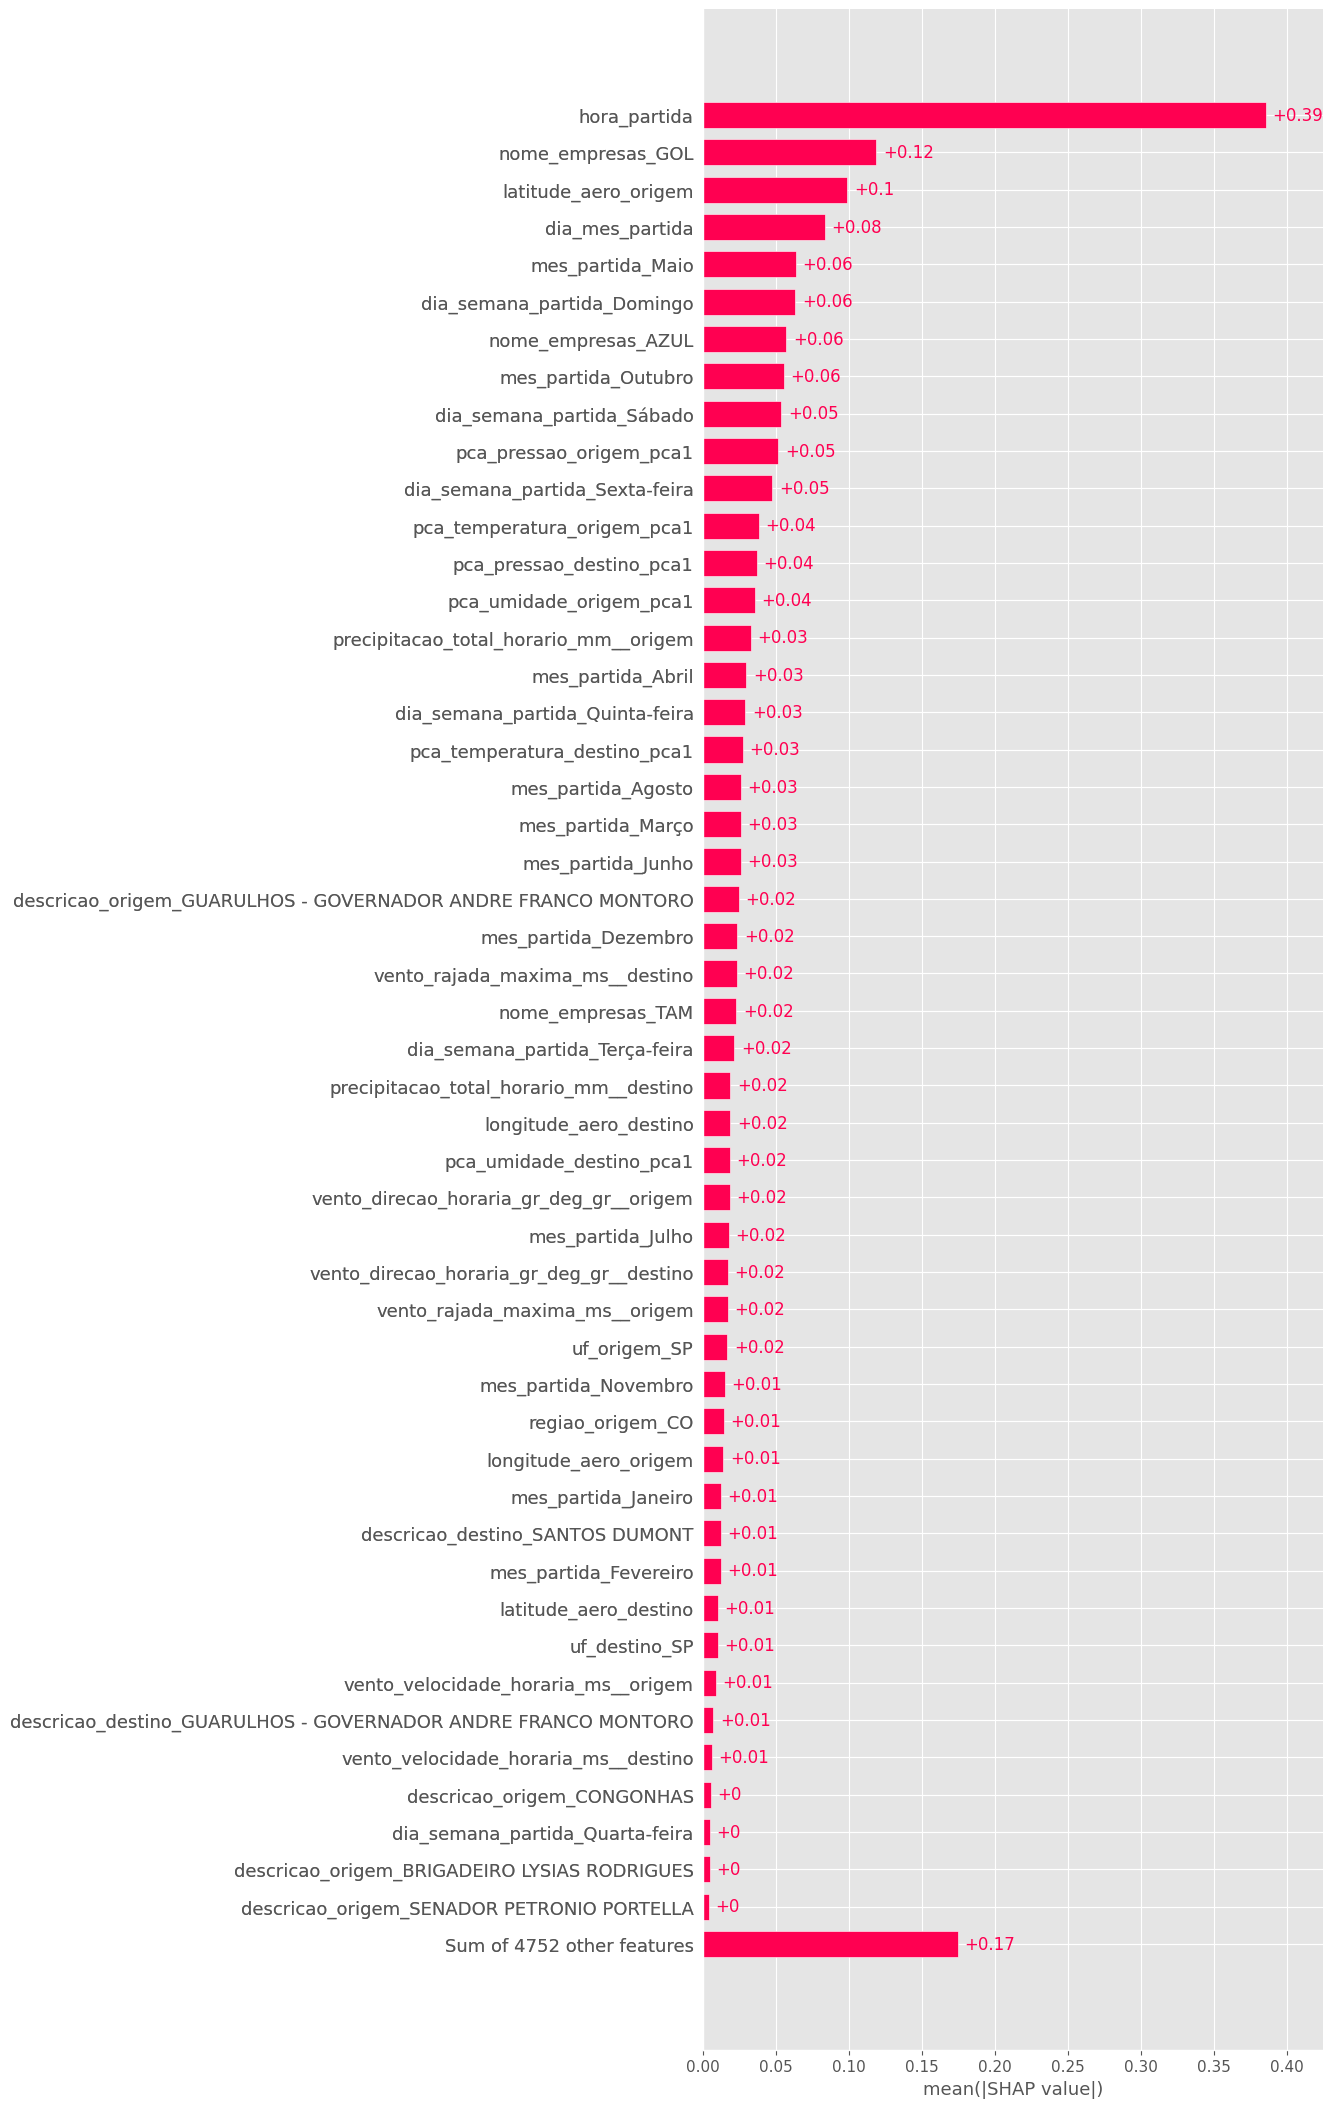

In [124]:
%%time
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_test_hot)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
#fig = plt.figure(figsize=(22, 21))
#plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
#plt.yticks(range(len(sorted_idx)), np.array(X_test_hot.columns)[sorted_idx])
#plt.title('SHAP Importance')
shap.plots.bar(shap_values, max_display=50)

Text(0.5, 1.0, 'SHAP Importance')

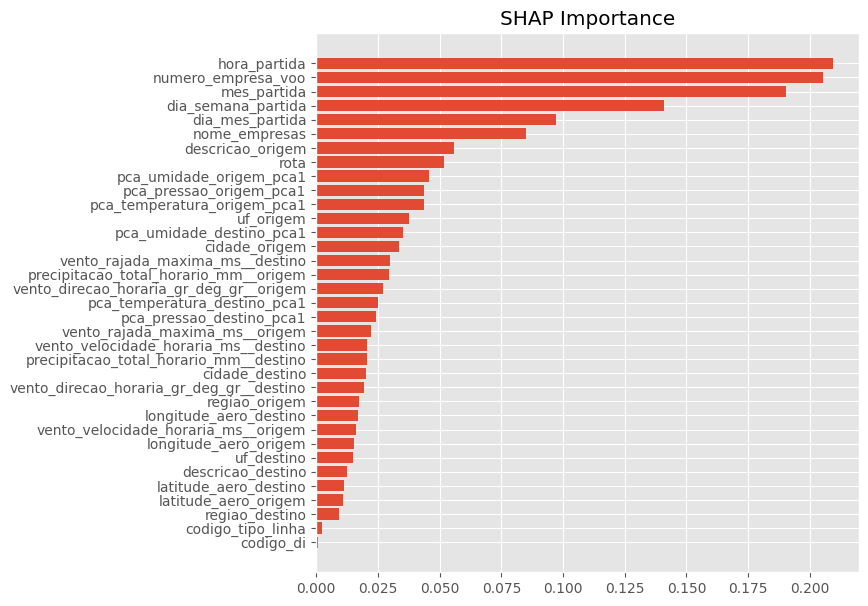

In [125]:
explainer = shap.Explainer(model_ctb)
shap_values = explainer(dt_ax)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(7, 7))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(dt_ax.columns)[sorted_idx])
plt.title('SHAP Importance')

### Recursive Feature Elimination

In [128]:
def engenharia_de_features_recursiva(modelo, X, y):
    """
    Aplica Recursive Feature Elimination (RFE) para selecionar as melhores features
    de acordo com a importância das variáveis no modelo fornecido.

    Parâmetros:
    -----------
    modelo : objeto do modelo
        O modelo de aprendizado de máquina a ser utilizado (pode ser qualquer modelo com `coef_` ou `feature_importances_`).
    X : pd.DataFrame ou np.array
        O conjunto de dados com as variáveis preditoras.
    y : pd.Series ou np.array
        O conjunto de dados com a variável alvo.

    Retorna:
    --------
    dict
        Um dicionário contendo:
        - 'modelo_rfe': O modelo RFE treinado.
        - 'n_features': O número de features selecionadas.
        - 'suporte': Um array booleano indicando as variáveis selecionadas.
        - 'ranking': O ranking das variáveis.
        - 'colunas_selecionadas': As colunas do DataFrame X que foram selecionadas.
    """
    
    # Aplicando RFE no modelo fornecido
    rfe = RFE(modelo)
    rfe_fit = rfe.fit(X, y)
    
    # Criando um dicionário com os resultados
    resultados_rfe = {
        'modelo_rfe': rfe_fit,
        'n_features': rfe_fit.n_features_,
        'suporte': rfe_fit.support_,
        'ranking': rfe_fit.ranking_,
        'colunas_selecionadas': X.columns[rfe_fit.support_].tolist()
    }
    
    return resultados_rfe

In [ ]:
# Exemplo de uso da função
resultado_rfe = engenharia_de_features_recursiva(model_xgb, X_train_hot, y_train_hot)

# Acessando as colunas significativas
colunas_significativas_rfe = resultado_rfe['colunas_selecionadas']

In [ ]:
colunas_significativas_rfe

In [136]:
## RFE Catboost
rfe_dict = model_ctb.select_features(X = dt_ax, 
                                     y = dt_ay, 
                                     features_for_select = '0-25',
                                     num_features_to_select = 25,
                                     steps = 2,
                                     train_final_model = False,
                                     plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

The number of features selection steps (2) is greater than the number of features to eliminate (1). The number of steps was reduced to 1.


Learning rate set to 0.132343
Step #1 out of 1
0:	learn: 0.6233349	total: 239ms	remaining: 3m 59s
1:	learn: 0.5705368	total: 521ms	remaining: 4m 19s
2:	learn: 0.5336218	total: 771ms	remaining: 4m 16s
3:	learn: 0.5054837	total: 1.03s	remaining: 4m 16s
4:	learn: 0.4849650	total: 1.31s	remaining: 4m 20s
5:	learn: 0.4710244	total: 1.56s	remaining: 4m 18s
6:	learn: 0.4590184	total: 1.8s	remaining: 4m 15s
7:	learn: 0.4499970	total: 2.04s	remaining: 4m 12s
8:	learn: 0.4426229	total: 2.27s	remaining: 4m 10s
9:	learn: 0.4382189	total: 2.48s	remaining: 4m 5s
10:	learn: 0.4342978	total: 2.71s	remaining: 4m 4s
11:	learn: 0.4313573	total: 2.94s	remaining: 4m 2s
12:	learn: 0.4286515	total: 3.23s	remaining: 4m 5s
13:	learn: 0.4262357	total: 3.51s	remaining: 4m 7s
14:	learn: 0.4243169	total: 3.73s	remaining: 4m 4s
15:	learn: 0.4226761	total: 3.96s	remaining: 4m 3s
16:	learn: 0.4213595	total: 4.23s	remaining: 4m 4s
17:	learn: 0.4203477	total: 4.52s	remaining: 4m 6s
18:	learn: 0.4196536	total: 4.75s	rem

In [137]:
rfe_dict

{'selected_features': [0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 'eliminated_features_names': ['codigo_di'],
 'loss_graph': {'main_indices': [0],
  'removed_features_count': [0, 1],
  'loss_values': [0.36104165059178406, 0.36104574644070825]},
 'eliminated_features': [1],
 'selected_features_names': ['nome_empresas',
  'codigo_tipo_linha',
  'descricao_origem',
  'descricao_destino',
  'cidade_origem',
  'uf_origem',
  'cidade_destino',
  'uf_destino',
  'mes_partida',
  'dia_semana_partida',
  'dia_mes_partida',
  'hora_partida',
  'latitude_aero_origem',
  'longitude_aero_origem',
  'latitude_aero_destino',
  'longitude_aero_destino',
  'rota',
  'regiao_origem',
  'precipitacao_total_horario_mm__origem',
  'vento_direcao_horaria_gr_deg_gr__origem',
  'vento_rajada_maxima_ms__origem',
  'vento_velocidade_horaria_ms__origem',
  'regiao_destino',
  'precipitacao_total_horario_mm__destino'

### Select From model

In [20]:
def selecao_variaveis_modelo(modelo, X_train, y_train, X_test, y_test, metric_func, metric_name="Metric", alpha=0.75) -> list:
    """
    Realiza a seleção de variáveis com base na importância das features de um modelo CatBoost, LightGBM ou XGBoost.
    Para cada limiar de importância, treina um modelo e avalia a métrica especificada.

    Parâmetros:
    -----------
    modelo : objeto treinado (CatBoost, LightGBM ou XGBoost)
        O modelo já treinado (de qualquer uma das três bibliotecas suportadas).
    X_train : pd.DataFrame ou np.array
        O conjunto de treino com as variáveis preditoras.
    y_train : pd.Series ou np.array
        O conjunto de treino com a variável alvo.
    X_test : pd.DataFrame ou np.array
        O conjunto de teste com as variáveis preditoras.
    y_test : pd.Series ou np.array
        O conjunto de teste com a variável alvo.
    metric_func : function
        A função de métrica que será usada para avaliar o modelo (ex.: accuracy_score, f1_score).
    metric_name : str, opcional
        O nome da métrica, usado para impressão no output. O padrão é 'Metric'.
    alpha : float, opcional
        O limiar de desempenho acima do qual as variáveis selecionadas serão retornadas. O padrão é 0.90.

    Retorna:
    --------
    list
        Uma lista contendo os nomes ou índices das variáveis mais importantes selecionadas pelo modelo.
    """

    # Obter importâncias das features do modelo
    if hasattr(modelo, "feature_importances_"):
        feature_importances = modelo.feature_importances_
    elif hasattr(modelo, "get_feature_importance"):
        feature_importances = modelo.get_feature_importance()
    else:
        raise ValueError("O modelo fornecido não suporta a obtenção de importâncias das features.")

    # Previsões iniciais e avaliação
    predictions = modelo.predict(X_test)
    metric_value = metric_func(y_test, predictions)
    print(f"{metric_name} inicial: {metric_value:.2f}")

    # Ordenar as importâncias das features
    thresholds = np.sort(feature_importances)
    
    variaveis_selecionadas = []
    
    # Iterar por cada limiar de importância
    for thresh in thresholds:
        # Selecionar features usando o limiar atual
        selection = SelectFromModel(modelo, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)

        # Verificar se o modelo é do tipo CatBoost, LightGBM ou XGBoost e treinar o modelo adequado
        if isinstance(modelo, xgb.XGBClassifier):
            selection_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbose=False)
        elif isinstance(modelo, lgb.LGBMClassifier):
            selection_model = lgb.LGBMClassifier()
        elif isinstance(modelo, catboost.CatBoostClassifier):
            selection_model = catboost.CatBoostClassifier(verbose=0)
        else:
            raise ValueError("O modelo fornecido não é suportado. Use CatBoost, LightGBM ou XGBoost.")

        # Treinar o modelo com as features selecionadas
        selection_model.fit(select_X_train, y_train)

        # Avaliar o modelo com as features selecionadas
        select_X_test = selection.transform(X_test)
        predictions = selection_model.predict(select_X_test)
        metric_value = metric_func(y_test, predictions)
        print(f"Thresh={thresh:.3f}, n={select_X_train.shape[1]}, {metric_name}: {metric_value:.2f}")

        # Se a métrica com o limiar atual for boa, armazenar as variáveis
        if metric_value > alpha:
            variaveis_selecionadas.append(select_X_train)

    return variaveis_selecionadas

In [21]:
variaveis_importantes_xgb = selecao_variaveis_modelo(model_xgb, X_train_hot, y_train_hot, X_test_hot, y_test_hot, accuracy_score, "Acurácia")

Acurácia inicial: 0.83
Thresh=0.000, n=4801, Acurácia: 0.83
Thresh=0.000, n=4801, Acurácia: 0.83
Thresh=0.000, n=4801, Acurácia: 0.83
Thresh=0.000, n=4801, Acurácia: 0.83
Thresh=0.000, n=4801, Acurácia: 0.83
Thresh=0.000, n=4801, Acurácia: 0.83
Thresh=0.000, n=4801, Acurácia: 0.83
Thresh=0.000, n=4801, Acurácia: 0.83
Thresh=0.000, n=4801, Acurácia: 0.83
Thresh=0.000, n=4801, Acurácia: 0.83
Thresh=0.000, n=4801, Acurácia: 0.83


MemoryError: Unable to allocate 10.6 GiB for an array with shape (4801, 296284) and data type float64

In [ ]:
variaveis_importantes_xgb